# Example-44: Twiss (Computation of chromatic Twiss parameters)

In [1]:
# In this example chromatic Twiss parameters are computed (derivatives of Twiss parameters with respect to momentum deviation)

In [2]:
# Import

from pprint import pprint

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt

from model.library.corrector import Corrector
from model.library.line import Line

from model.command.util import chop
from model.command.util import select

from model.command.external import load_sdds
from model.command.external import load_lattice

from model.command.build import build

from model.command.tune import tune
from model.command.twiss import twiss
from model.command.twiss import chromatic_twiss

In [3]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

nu_qx:Tensor = torch.tensor(parameters['nux'] % 1, dtype=torch.float64)
nu_qy:Tensor = torch.tensor(parameters['nuy'] % 1, dtype=torch.float64)

# Set twiss parameters at BPMs

kinds = select(columns, 'ElementType', keep=False)

a_qx = select(columns, 'alphax', keep=False)
b_qx = select(columns, 'betax' , keep=False)
a_qy = select(columns, 'alphay', keep=False)
b_qy = select(columns, 'betay' , keep=False)

a_qx:Tensor = torch.tensor([value for (key, value), kind in zip(a_qx.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)
b_qx:Tensor = torch.tensor([value for (key, value), kind in zip(b_qx.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)
a_qy:Tensor = torch.tensor([value for (key, value), kind in zip(a_qy.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)
b_qy:Tensor = torch.tensor([value for (key, value), kind in zip(b_qy.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)

positions = select(columns, 's', keep=False).items()
positions = [value for (key, value), kind in zip(positions, kinds.values()) if kind == 'MONI']

In [4]:
# Build and setup lattice

# Note, sextupoles are turned off and dipoles are linear 

# Load ELEGANT table

path = Path('ic.lte')
data = load_lattice(path)

# Build ELEGANT table

ring:Line = build('RING', 'ELEGANT', data)
ring.flatten()

# Merge drifts

ring.merge()

# Turn off sextupoles and set linear dipoles

for element in ring: 
    if element.__class__.__name__ == 'Sextupole':
        element.ms = 0.0
    if element.__class__.__name__ == 'Dipole':
        element.linear = True

# Set number of elements of different kinds

nb = ring.describe['BPM']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

In [5]:
# Compute tunes (fractional part)

guess = torch.tensor(4*[0.0], dtype=torch.float64)
nuqx, nuqy = tune(ring, [], alignment=False, matched=True, guess=guess, limit=8, epsilon=1.0E-9)

# Compare with elegant

print(torch.allclose(nu_qx, nuqx))
print(torch.allclose(nu_qy, nuqy))

True
True


In [6]:
# First, we compute derivatives of Twiss parameters from linear fit

dps = torch.linspace(-1.0E-6, 1.0E-6, 5, dtype=torch.float64)

def fn(dp):
    table = twiss(ring, 
                  [dp], 
                  ('dp', None, None, None), 
                  alignment=False, 
                  matched=True,
                  advance=True, 
                  full=False, 
                  limit=16,
                  epsilon=None)
    return table

data = torch.func.vmap(fn)(dps).swapaxes(0, 1)
print(data.shape)

solution = torch.linalg.lstsq(dps.unsqueeze(1).expand(len(ring), -1, -1), data, driver='gels').solution.squeeze()
daqxdp_fit, dbqxdp_fit, daqydp_fit, dbqydp_fit = solution.T
print(solution.shape)

torch.Size([136, 5, 4])
torch.Size([136, 4])


In [7]:
# The above function is differentiable and can be used to compute derivatives directly
# Or use convinience wrapper function, model.command.twiss.chromatic_twiss

dp = torch.tensor([0.0], dtype=torch.float64)

out_a = torch.func.jacrev(fn)(dp).squeeze()
out_b = chromatic_twiss(ring, [], alignment=False, matched=True, advance=True, full=False, limit=16, epsilon=None)
print(torch.allclose(out_a, out_b))

True


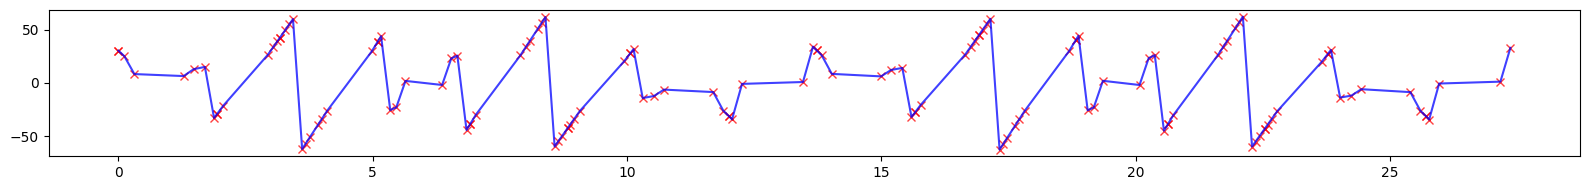

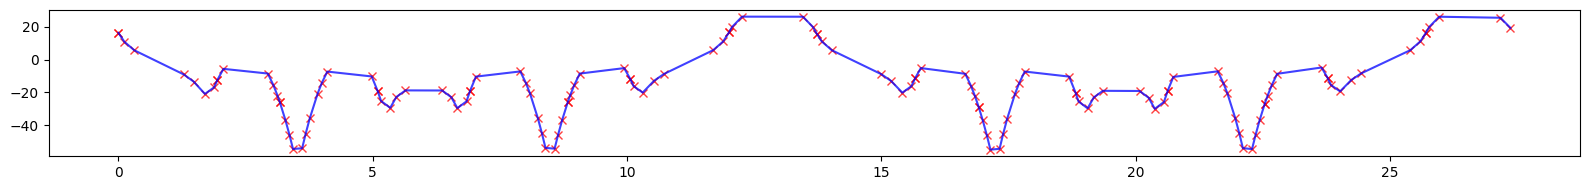

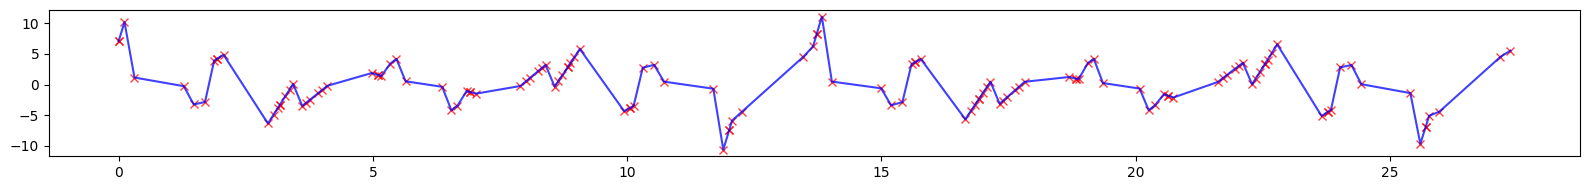

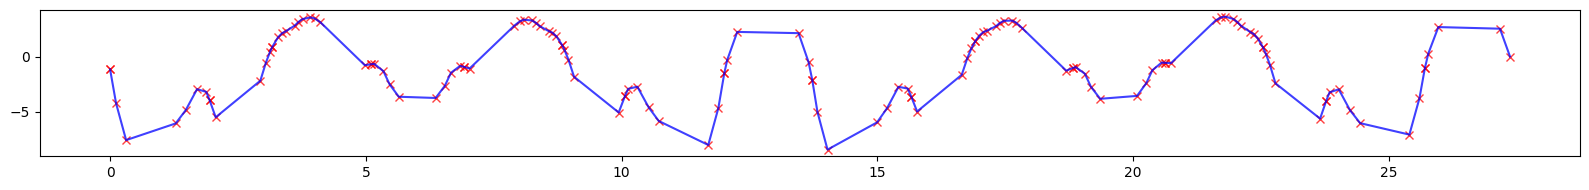

In [8]:
# Plot and compare chromatic Twiss parametes

daqxdp, dbqxdp, daqydp, dbqydp = out_a.T

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), daqxdp_fit.cpu().numpy(), fmt=' ', color='red', marker='x', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), daqxdp.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), dbqxdp_fit.cpu().numpy(), fmt=' ', color='red', marker='x', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), dbqxdp.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), daqydp_fit.cpu().numpy(), fmt=' ', color='red', marker='x', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), daqydp.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), dbqydp_fit.cpu().numpy(), fmt=' ', color='red', marker='x', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), dbqydp.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
plt.tight_layout()
plt.show()